In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as du
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import einops
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import r2_score


### Defining Dataset

In [2]:
'''
For this project, I will be using sequential based nn models (rnn, lstm, gru)
to predict hourly temperatures of the Irish city Galway using previous temperatures
https://www.kaggle.com/datasets/conorrot/irish-weather-hourly-data
dataset was too big to upload to github
'''

df = pd.read_csv("datasets/hrly_Irish_weather.csv", low_memory=False)
print(df.shape)
df.head()

(4660423, 18)


,county,station,latitude,longitude,date,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,sun,vis,clht,clamt
0,Galway,ATHENRY,53.289,-8.786,26-jun-2011 01:00,0.0,15.3,14.5,13.9,15.8,90,1016.0,8,190,NaN,NaN,NaN,NaN
1,Galway,ATHENRY,53.289,-8.786,26-jun-2011 02:00,0.0,14.7,13.7,12.9,14.9,89,1015.8,7,190,NaN,NaN,NaN,NaN
2,Galway,ATHENRY,53.289,-8.786,26-jun-2011 03:00,0.0,14.3,13.4,12.6,14.6,89,1015.5,6,190,NaN,NaN,NaN,NaN
3,Galway,ATHENRY,53.289,-8.786,26-jun-2011 04:00,0.0,14.4,13.6,12.8,14.8,90,1015.3,7,180,NaN,NaN,NaN,NaN
4,Galway,ATHENRY,53.289,-8.786,26-jun-2011 05:00,0.0,14.4,13.5,12.7,14.7,89,1015.1,6,190,NaN,NaN,NaN,NaN


### Proprocessing Dataset

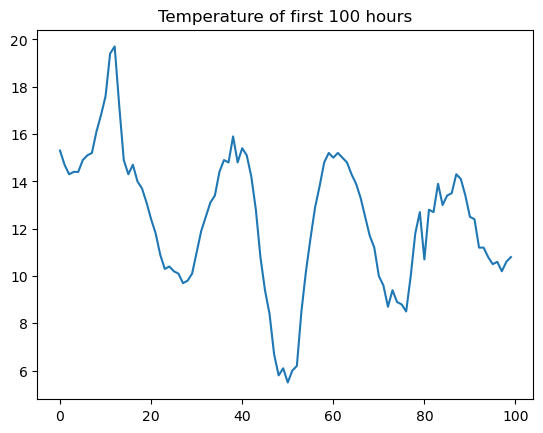

(4214711, 8)


,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp
0,0.0,15.3,14.5,13.9,15.8,90.0,1016.000000,8.0
1,0.0,14.7,13.7,12.9,14.9,89.0,1015.799988,7.0
2,0.0,14.3,13.4,12.6,14.6,89.0,1015.500000,6.0
3,0.0,14.4,13.6,12.8,14.8,90.0,1015.299988,7.0
4,0.0,14.4,13.5,12.7,14.7,89.0,1015.099976,6.0


In [3]:
df = df.drop(["date", "latitude", "longitude", "station", "county", "wddir", "sun", "vis", "clht", "clamt"], axis=1) # droping non numerical columns
# df = df.dropna()
df = df[df != " "] # droping all rows with non numerical values 
df = df.astype("float32")  # converting data to float
df = df.dropna()
df.temp[:100].plot(title="Temperature of first 100 hours") # ploting first 100 hours
plt.show()
irish_data = df.values
print(irish_data.shape)
df.head()

### Extracting features and targets from dataset
The RNN model takes in a sequence with 8 features in each time stamp and outputs a sequence of the same length with 1 output per timestamp. It has a single hidden layer and a dropout layer for regularization. The output of the RNN will be the prediction

In [4]:
class weather_data(Dataset):
    '''
    data: dataset
    seq_len: length of time series
    offset: how much to slide window
    generates sequences of length seq_len with a sliding window 
    '''
    def __init__(self, data, seq_len, offset, train=False):
        super(weather_data, self).__init__()
        sc = MinMaxScaler()
        data = sc.fit_transform(data)
        self.seq_len = seq_len
        self.x = []
        self.y = []
        if(train):
            for i in range(0,data.shape[0]-seq_len, offset): # collecting sequences using sliding window technique
                self.x.append(data[i:i+seq_len])
                self.y.append(data[i+1:i+1+seq_len,1])  
        else:
            for i in range(0,data.shape[0]-seq_len, offset):
                self.x.append(data[i:i+seq_len])
                self.y.append(data[i+1:i+1+seq_len,1]) 

        self.x = np.array(self.x)
        self.y = np.array(self.y)
        self.x = torch.tensor(self.x)
        self.y = torch.tensor(self.y)

    def __len__(self):
        '''return len of dataset'''
        return self.x.shape[0]
    def __getitem__(self, idx):
        '''return sequence, future sequence'''
        return self.x[idx], self.y[idx]

### Defining the model
All three variants are created using the same class. The variant of RNN is specified as a parameter

In [5]:
class TIME_SERIES_MODEL(nn.Module):
    def __init__(self, in_feat, hidden_layers, num_layers, out_dim, dropout, network):
        '''
        in_dim: input layer dim
        hidden_layers: hidden layers in lstm
        '''
        super(TIME_SERIES_MODEL, self).__init__()
        if(network == "LSTM"):
            self.time_series_model = nn.LSTM(in_feat, hidden_layers, num_layers, dropout=dropout, batch_first=True)
        elif(network == "GRU"):
            self.time_series_model= nn.GRU(in_feat, hidden_layers, num_layers, dropout=dropout, batch_first=True)
        elif(network == "RNN"):
            self.time_series_model = nn.RNN(in_feat, hidden_layers, num_layers, dropout=dropout, batch_first=True)
        else:
            print("Invalid model type specified, defaulting to RNN")
            self.time_series_model = nn.RNN(in_feat, hidden_layers, num_layers, batch_first = True)
        self.linear = nn.Linear(hidden_layers, out_dim)
        self.num_layers = num_layers
        self.hidden_layers = hidden_layers
        self.network = network

    def forward(self, x):
        x, _ = self.time_series_model(x)
        return x

In [6]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"using device: {device}")
batch_size = 256
learning_rate = 0.1
max_epochs = 10
in_feat = 8
hidden_dim = 1
num_layers = 1
dropout = .1
seq_len = 1000
offset = 20

rnn_model = TIME_SERIES_MODEL(in_feat, hidden_dim, num_layers, seq_len, dropout, "RNN")
lstm_model = TIME_SERIES_MODEL(in_feat, hidden_dim, num_layers, seq_len, dropout, "LSTM")
gru_model = TIME_SERIES_MODEL(in_feat, hidden_dim, num_layers, seq_len, dropout, "GRU")
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=learning_rate)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)
gru_optimizer = optim.Adam(gru_model.parameters(), lr=learning_rate)

# load training data in batches
train_data = irish_data[:int(irish_data.shape[0]*.8)]
valid_data = irish_data[int(irish_data.shape[0]*.8):int(irish_data.shape[0]*.9)]
test_data = irish_data[int(irish_data.shape[0]*.9):]
train_loader = du.DataLoader(dataset=weather_data(train_data, seq_len, offset, True),
                             batch_size=batch_size,
                             shuffle=True)
valid_loader = du.DataLoader(dataset=weather_data(valid_data, seq_len, offset),
                             batch_size=batch_size,
                             shuffle=True)
test_loader = du.DataLoader(dataset=weather_data(test_data, seq_len, offset),
                             batch_size=batch_size,
                             shuffle=False)
# send model over to device
rnn_model = rnn_model.to(device)
lstm_model = lstm_model.to(device)
gru_model = gru_model.to(device)
rnn_model.train()
lstm_model.train()
gru_model.train()

using device: cuda:0


c:\Users\lij47\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


TIME_SERIES_MODEL(
  (time_series_model): GRU(8, 1, batch_first=True, dropout=0.1)
  (linear): Linear(in_features=1, out_features=1000, bias=True)
)

### Training Loop
All the models are trained at the same time.

R2 score is the evaluation metric because the target is continuous. MSE can also be used as an evaluation metric but mse is used as the loss function so I chose to use a different evaluation metric to better capture the performance of the models.

In [7]:
rnn_train_loss_list = []
rnn_valid_loss_list = []
lstm_train_loss_list = []
lstm_valid_loss_list = []
gru_train_loss_list = []
gru_valid_loss_list = []
rnn_train_r2_list = []
lstm_train_r2_list = []
gru_train_r2_list = []
rnn_valid_r2_list = []
lstm_valid_r2_list = []
gru_valid_r2_list = []
# iterating through all epochs
for epoch in range(1, max_epochs + 1):    
    # training step
    rnn_train_loss = 0.
    lstm_train_loss = 0.
    gru_train_loss = 0.
    rnn_model.train()
    lstm_model.train()
    gru_model.train()
    epoch_rnn_train_r2_list = []
    epoch_lstm_train_r2_list = []
    epoch_gru_train_r2_list = []
    # iterating through entire dataset in batches
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        # sending batch over to device
        data, target = data.to(device), target.to(device)
        # zeroing out previous gradients
        rnn_optimizer.zero_grad()
        lstm_optimizer.zero_grad()
        gru_optimizer.zero_grad()
        # getting predictions from model
        rnn_pred = rnn_model(data).squeeze(dim=-1)
        lstm_pred = lstm_model(data).squeeze(dim=-1)
        gru_pred = gru_model(data).squeeze(dim=-1)
        # claculating mse loss
        rnn_loss = F.mse_loss(rnn_pred, target)
        lstm_loss = F.mse_loss(lstm_pred, target)
        gru_loss = F.mse_loss(gru_pred, target)
        rnn_train_loss += rnn_loss.item()
        lstm_train_loss += lstm_loss.item()
        gru_train_loss += gru_loss.item()
        # backprop
        rnn_loss.backward()
        lstm_loss.backward()
        gru_loss.backward()
        rnn_optimizer.step()
        lstm_optimizer.step()
        gru_optimizer.step()
        epoch_rnn_train_r2_list.append(r2_score(target.detach().cpu().numpy(), rnn_pred.detach().cpu().numpy()))
        epoch_lstm_train_r2_list.append(r2_score(target.detach().cpu().numpy(), lstm_pred.detach().cpu().numpy()))
        epoch_gru_train_r2_list.append(r2_score(target.detach().cpu().numpy(), gru_pred.detach().cpu().numpy()))
    
    # validation step
    rnn_valid_loss = 0
    lstm_valid_loss = 0
    gru_valid_loss = 0
    epoch_rnn_valid_r2_list = []
    epoch_lstm_valid_r2_list = []
    epoch_gru_valid_r2_list = []
    # turning off grad for validation step
    rnn_model.eval()
    lstm_model.eval()
    gru_model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(valid_loader)):
            data, target = data.to(device), target.to(device)
            rnn_pred = rnn_model(data).squeeze(dim=-1)
            lstm_pred = lstm_model(data).squeeze(dim=-1)
            gru_pred = gru_model(data).squeeze(dim=-1)
            rnn_loss = F.mse_loss(rnn_pred, target)
            lstm_loss = F.mse_loss(lstm_pred, target)
            gru_loss = F.mse_loss(gru_pred, target)
            rnn_valid_loss += rnn_loss.item()
            lstm_valid_loss += lstm_loss.item()
            gru_valid_loss += gru_loss.item()
            epoch_rnn_valid_r2_list.append(r2_score(target.detach().cpu().numpy(), rnn_pred.detach().cpu().numpy()))
            epoch_lstm_valid_r2_list.append(r2_score(target.detach().cpu().numpy(), lstm_pred.detach().cpu().numpy()))
            epoch_gru_valid_r2_list.append(r2_score(target.detach().cpu().numpy(), gru_pred.detach().cpu().numpy()))
            
    # calculating average loss
    rnn_train_loss /= len(train_loader.dataset)
    lstm_train_loss /= len(train_loader.dataset)
    gru_train_loss /= len(train_loader.dataset)
    rnn_valid_loss /= len(valid_loader.dataset)
    lstm_valid_loss /= len(valid_loader.dataset)
    gru_valid_loss /= len(valid_loader.dataset)
    rnn_train_r2_score = sum(epoch_rnn_train_r2_list) / len(epoch_rnn_train_r2_list)
    lstm_train_r2_score = sum(epoch_lstm_train_r2_list) / len(epoch_lstm_train_r2_list)
    gru_train_r2_score = sum(epoch_gru_train_r2_list) / len(epoch_gru_train_r2_list)
    rnn_valid_r2_score = sum(epoch_rnn_valid_r2_list) / len(epoch_rnn_valid_r2_list)
    lstm_valid_r2_score = sum(epoch_lstm_valid_r2_list) / len(epoch_lstm_valid_r2_list)
    gru_valid_r2_score = sum(epoch_gru_valid_r2_list) / len(epoch_gru_valid_r2_list)
    rnn_train_loss_list.append(rnn_train_loss)
    lstm_train_loss_list.append(lstm_train_loss)
    gru_train_loss_list.append(gru_train_loss)
    rnn_valid_loss_list.append(rnn_valid_loss)
    lstm_valid_loss_list.append(lstm_valid_loss)
    gru_valid_loss_list.append(gru_valid_loss)
    rnn_train_r2_list.append(rnn_train_r2_score)
    lstm_train_r2_list.append(lstm_train_r2_score)
    gru_train_r2_list.append(gru_train_r2_score)
    rnn_valid_r2_list.append(rnn_valid_r2_score)
    lstm_valid_r2_list.append(lstm_valid_r2_score)
    gru_valid_r2_list.append(gru_valid_r2_score)

    # printing loss per epoch
    print(f'RNN Epoch: {epoch}, Train Loss: {rnn_train_loss:.10f}, R2 Train Score: {rnn_train_r2_score:.3f}, Valid Loss: {rnn_valid_loss:.10f}, R2 Valid Score: {rnn_valid_r2_score:.3f}')
    print(f'LSTM Epoch: {epoch}, Train Loss: {lstm_train_loss:.10f}, R2 Train Score: {lstm_train_r2_score:.3f}, Valid Loss: {lstm_valid_loss:.10f}, R2 Valid Score: {lstm_valid_r2_score:.3f}')
    print(f'GRU Epoch: {epoch}, Train Loss: {gru_train_loss:.10f}, R2 Train Score: {gru_train_r2_score:.3f}, Valid Loss: {gru_valid_loss:.10f}, R2 Valid Score: {gru_valid_r2_score:.3f}')

100%|██████████| 83/83 [00:04<00:00, 20.13it/s]


RNN Epoch: 1, Train Loss: 0.0000081487, R2 Train Score: 0.795, Valid Loss: 0.0000123810, R2 Valid Score: 0.718
LSTM Epoch: 1, Train Loss: 0.0012799218, R2 Train Score: -31.238, Valid Loss: 0.0010916863, R2 Valid Score: -23.925
GRU Epoch: 1, Train Loss: 0.0000053810, R2 Train Score: 0.864, Valid Loss: 0.0000039546, R2 Valid Score: 0.910


100%|██████████| 83/83 [00:03<00:00, 21.16it/s]


RNN Epoch: 2, Train Loss: 0.0000014267, R2 Train Score: 0.964, Valid Loss: 0.0000102591, R2 Valid Score: 0.766
LSTM Epoch: 2, Train Loss: 0.0001935936, R2 Train Score: -3.901, Valid Loss: 0.0000064311, R2 Valid Score: 0.853
GRU Epoch: 2, Train Loss: 0.0000012030, R2 Train Score: 0.970, Valid Loss: 0.0000027946, R2 Valid Score: 0.936


100%|██████████| 83/83 [00:03<00:00, 21.11it/s]


RNN Epoch: 3, Train Loss: 0.0000015070, R2 Train Score: 0.962, Valid Loss: 0.0000060359, R2 Valid Score: 0.862
LSTM Epoch: 3, Train Loss: 0.0000020386, R2 Train Score: 0.949, Valid Loss: 0.0000064001, R2 Valid Score: 0.853
GRU Epoch: 3, Train Loss: 0.0000011748, R2 Train Score: 0.970, Valid Loss: 0.0000020902, R2 Valid Score: 0.952


100%|██████████| 83/83 [00:03<00:00, 24.03it/s]


RNN Epoch: 4, Train Loss: 0.0000017514, R2 Train Score: 0.956, Valid Loss: 0.0000035190, R2 Valid Score: 0.920
LSTM Epoch: 4, Train Loss: 0.0000020290, R2 Train Score: 0.949, Valid Loss: 0.0000064062, R2 Valid Score: 0.854
GRU Epoch: 4, Train Loss: 0.0000011625, R2 Train Score: 0.971, Valid Loss: 0.0000016074, R2 Valid Score: 0.963


100%|██████████| 83/83 [00:03<00:00, 23.49it/s]


RNN Epoch: 5, Train Loss: 0.0000016960, R2 Train Score: 0.957, Valid Loss: 0.0000042342, R2 Valid Score: 0.904
LSTM Epoch: 5, Train Loss: 0.0000020229, R2 Train Score: 0.949, Valid Loss: 0.0000066621, R2 Valid Score: 0.847
GRU Epoch: 5, Train Loss: 0.0000011823, R2 Train Score: 0.970, Valid Loss: 0.0000015899, R2 Valid Score: 0.964


100%|██████████| 83/83 [00:04<00:00, 19.99it/s]


RNN Epoch: 6, Train Loss: 0.0000017273, R2 Train Score: 0.957, Valid Loss: 0.0000035329, R2 Valid Score: 0.919
LSTM Epoch: 6, Train Loss: 0.0000020156, R2 Train Score: 0.950, Valid Loss: 0.0000075679, R2 Valid Score: 0.827
GRU Epoch: 6, Train Loss: 0.0000011700, R2 Train Score: 0.971, Valid Loss: 0.0000015922, R2 Valid Score: 0.964


100%|██████████| 83/83 [00:03<00:00, 21.54it/s]


RNN Epoch: 7, Train Loss: 0.0000017154, R2 Train Score: 0.957, Valid Loss: 0.0000033340, R2 Valid Score: 0.924
LSTM Epoch: 7, Train Loss: 0.0000020102, R2 Train Score: 0.950, Valid Loss: 0.0000070512, R2 Valid Score: 0.838
GRU Epoch: 7, Train Loss: 0.0000011557, R2 Train Score: 0.971, Valid Loss: 0.0000014363, R2 Valid Score: 0.967


100%|██████████| 83/83 [00:04<00:00, 16.77it/s]


RNN Epoch: 8, Train Loss: 0.0000016918, R2 Train Score: 0.958, Valid Loss: 0.0000036305, R2 Valid Score: 0.917
LSTM Epoch: 8, Train Loss: 0.0000020070, R2 Train Score: 0.950, Valid Loss: 0.0000077270, R2 Valid Score: 0.823
GRU Epoch: 8, Train Loss: 0.0000011461, R2 Train Score: 0.971, Valid Loss: 0.0000016289, R2 Valid Score: 0.963


100%|██████████| 83/83 [00:03<00:00, 21.61it/s]


RNN Epoch: 9, Train Loss: 0.0000017160, R2 Train Score: 0.957, Valid Loss: 0.0000028951, R2 Valid Score: 0.934
LSTM Epoch: 9, Train Loss: 0.0000020042, R2 Train Score: 0.950, Valid Loss: 0.0000079349, R2 Valid Score: 0.818
GRU Epoch: 9, Train Loss: 0.0000011413, R2 Train Score: 0.971, Valid Loss: 0.0000013492, R2 Valid Score: 0.969


100%|██████████| 83/83 [00:03<00:00, 21.06it/s]

RNN Epoch: 10, Train Loss: 0.0000017153, R2 Train Score: 0.957, Valid Loss: 0.0000025156, R2 Valid Score: 0.943
LSTM Epoch: 10, Train Loss: 0.0000018441, R2 Train Score: 0.954, Valid Loss: 0.0000115271, R2 Valid Score: 0.737
GRU Epoch: 10, Train Loss: 0.0000011260, R2 Train Score: 0.972, Valid Loss: 0.0000013042, R2 Valid Score: 0.970


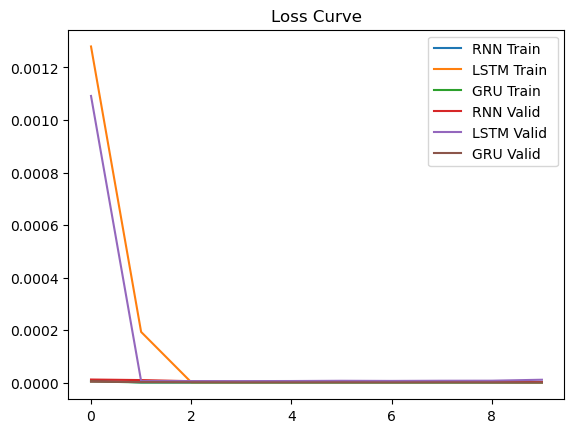

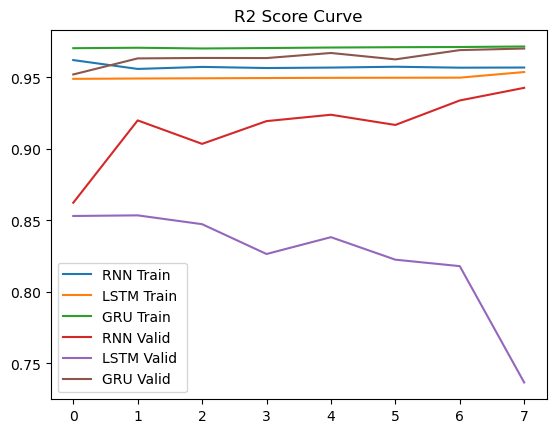

In [11]:
plt.plot(rnn_train_loss_list, label="RNN Train")
plt.plot(lstm_train_loss_list, label="LSTM Train")
plt.plot(gru_train_loss_list, label="GRU Train")
plt.plot(rnn_valid_loss_list, label="RNN Valid")
plt.plot(lstm_valid_loss_list, label="LSTM Valid ")
plt.plot(gru_valid_loss_list, label="GRU Valid")
plt.title("Loss Curve")
plt.legend()
plt.show()
plt.plot(rnn_train_r2_list[2:], label="RNN Train") # removing first epoch because it will mess up the scale
plt.plot(lstm_train_r2_list[2:], label="LSTM Train")
plt.plot(gru_train_r2_list[2:], label="GRU Train")
plt.plot(rnn_valid_r2_list[2:], label="RNN Valid")
plt.plot(lstm_valid_r2_list[2:], label="LSTM Valid ")
plt.plot(gru_valid_r2_list[2:], label="GRU Valid")
plt.title("R2 Score Curve")
plt.legend()
plt.show()

In [9]:
# testing step
rnn_test_loss = 0
lstm_test_loss = 0
gru_test_loss = 0
rnn_test_r2_list = []
lstm_test_r2_list = []
gru_test_r2_list = []
# turning off grad for testing step
rnn_model.eval()
lstm_model.eval()
gru_model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
        data, target = data.to(device), target.to(device)
        rnn_pred = rnn_model(data).squeeze(dim=-1)
        lstm_pred = lstm_model(data).squeeze(dim=-1)
        gru_pred = gru_model(data).squeeze(dim=-1)
        rnn_loss = F.mse_loss(rnn_pred, target)
        lstm_loss = F.mse_loss(lstm_pred, target)
        gru_loss = F.mse_loss(gru_pred, target)
        rnn_test_loss += rnn_loss.item()
        lstm_test_loss += lstm_loss.item()
        gru_test_loss += gru_loss.item()
        rnn_test_r2_list.append(r2_score(target.detach().cpu().numpy(), rnn_pred.detach().cpu().numpy()))
        lstm_test_r2_list.append(r2_score(target.detach().cpu().numpy(), lstm_pred.detach().cpu().numpy()))
        gru_test_r2_list.append(r2_score(target.detach().cpu().numpy(), gru_pred.detach().cpu().numpy()))
        if(batch_idx == 0):
            rnn_prediction = rnn_pred
            lstm_prediction = lstm_pred
            gru_prediction = gru_pred
            actual = target

        
# calculating average loss
rnn_test_loss /= len(test_loader.dataset)
lstm_test_loss /= len(test_loader.dataset)
gru_test_loss /= len(test_loader.dataset)
rnn_test_r2_score = sum(rnn_test_r2_list) / len(rnn_test_r2_list)
lstm_test_r2_score = sum(lstm_test_r2_list) / len(lstm_test_r2_list)
gru_test_r2_score = sum(gru_test_r2_list) / len(gru_test_r2_list)

# printing loss per epoch
print(f'RNN Test Loss: {rnn_test_loss:.10f}, R2 test Score: {rnn_test_r2_score:.3f}')
print(f'LSTM Test Loss: {lstm_test_loss:.10f}, R2 test Score: {lstm_test_r2_score:.3f}')
print(f'GRU Test Loss: {gru_test_loss:.10f}, R2 test Score: {gru_test_r2_score:.3f}')

100%|██████████| 83/83 [00:03<00:00, 20.89it/s]

RNN Test Loss: 0.0000026491, R2 test Score: 0.923
LSTM Test Loss: 0.0000156860, R2 test Score: 0.528
GRU Test Loss: 0.0000017912, R2 test Score: 0.947


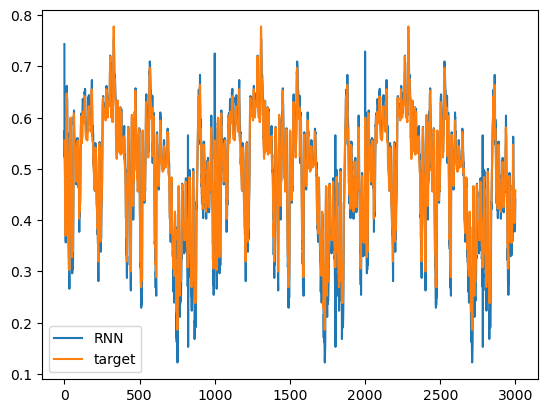

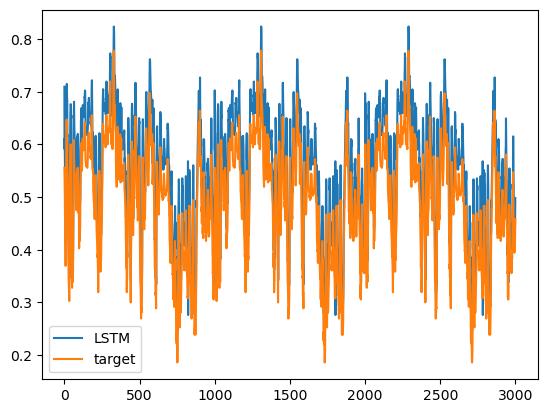

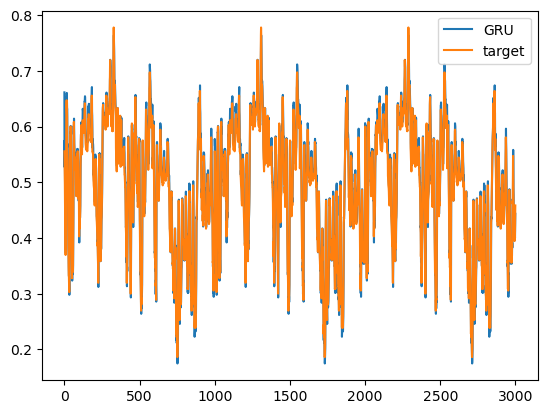

In [10]:
rnn_prediction = rnn_prediction.reshape(-1).detach().cpu().numpy()[:3000]
lstm_prediction = lstm_prediction.reshape(-1).detach().cpu().numpy()[:3000]
gru_prediction = gru_prediction.reshape(-1).detach().cpu().numpy()[:3000]
actual = actual.reshape(-1).detach().cpu().numpy()[:3000]
plt.plot(rnn_prediction, label="RNN")
plt.plot(actual, label="target")
plt.legend()
plt.show()
plt.plot(lstm_prediction, label="LSTM")
plt.plot(actual, label="target")
plt.legend()
plt.show()
plt.plot(gru_prediction, label="GRU")
plt.plot(actual, label="target")
plt.legend()
plt.show()

### Write Up 

Comparing the results from the testing dataset, vanilla RNN and GRU both performed very well while LSTM had a lower accuracy. In addition, RNN and GRU had smoother training, which is indicated by the smoother loss and R2 curve and faster convergence. From the R2 Curve for LSTM, we can see that LSTM had good training accuracy but struggled to converge for validation accuracy. In the testing set, RNN and GRU performed well but LSTM performed mediocrely. This means that LSTM struggled to generalize compared to RNN and GRU and overfitted. From an architectural standpoint, it shows that the extra gates that LSTM provided did not help the LSTM to retain information and actually caused it to memorize the dataset rather than generalize and learn patterns. However, we can see from the loss/ R2 curve for training/validaiton, and the testing scores, that GRU performed slightly better than RNN. On the plot of predictions and targets, we can see that GRU fit the line the best. This means that the cell state and gates for a GRU helped it to retain previous time stamps better than RNN and lead to higher prediction accuracy.  

A traditional neural network can be used to solve a similar task to what I performed by adding positional encoding to the data. RNNs are good for time series data because the models explicitly use previous time stamps as part of the prediction of future timestamps. By adding positional encoding, the mlp can learn to weigh previous timestamps of close procximity to predict future timestamps. This techinique might be finicky and require alot of parameter tuning to work but it should be possible. 